<a href="https://colab.research.google.com/github/almendruki/Cosas-TDA/blob/main/Almendra_Orellana_Figueroa_CLase_8_Tutorial_de_complejos_simpliciales_a_persistencia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TDA — Clase 8: Tutorial De complejos simpliciales a diagramas de persistencia
#
## **Objetivo del notebook**
# - Mostrar desde la definición de simplex y frontera hasta la obtención de diagramas de persistencia.
# - Proveer preguntas intermedias y una pequeña tarea final (separada).

In [ ]:
# - Usamos el término *simplex* / *simplices* (no "simplejo").
# - Para mantener la didáctica usaremos coeficientes en $\mathbb{F}_2$ (módulo 2) cuando sea conveniente,
#   así evitamos manejar orientaciones explícitas en los ejemplos computacionales. Esto facilita comprobar
#   la identidad `boundary(boundary(.)) == 0` y realizar reducción por filas sobre GF(2).

In [2]:
#Instalación (si corresponde)
!pip install numpy scipy matplotlib networkx ripser scikit-tda gudhi

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 842.1/842.1 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 3.7 MB/s eta 0:00:00
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18104 sha256=ff70a8cc2f3d859f94343d61e80e76e632e09ad42f04eeb7fc49a5697beacf05
  Stored in directory: /root/.cache/pip/wheels/2a/fd/fe/f4b8fd82894e1d9e04040ef41dc5ae6eb7a8e9b0ef5a9402fe
Successfully built hopcroftkarp


## 1) Representación básica: simplex, caras y frontera

Implementaremos:
- `faces(simplex)` — devuelve las caras (subconjuntos con un vértice menos).
- `boundary_mod2(simplex)` — frontera de un simplex en coeficientes módulo 2.

Representación: un *simplex* será un `tuple` ordenado de vértices (strings o enteros).

In [3]:
from itertools import combinations
from typing import Tuple, List, Set

Simplex = Tuple

def faces(simplex: Simplex) -> List[Simplex]:
    """Devuelve las caras de dimensión (d-1) de un simplex de dimensión d.
    El resultado está en forma de tuplas ordenadas (orden lexicográfico por defecto).
    """
    if len(simplex) <= 1:
        return []
    return [tuple(s) for s in combinations(simplex, len(simplex)-1)]

def boundary_mod2(simplex: Simplex) -> List[Simplex]:
    """Frontera en coeficientes mod 2: la frontera es la suma (simétrica) de sus caras.
    Para coeficientes en Z2 podemos devolver la lista de caras (sin signos).
    """
    return faces(simplex)

# Ejemplo
s = ('A','B','C')
print('Simplex:', s)
print('Caras:', faces(s))
print('Frontera mod2:', boundary_mod2(s))

Simplex: ('A', 'B', 'C')
Caras: [('A', 'B'), ('A', 'C'), ('B', 'C')]
Frontera mod2: [('A', 'B'), ('A', 'C'), ('B', 'C')]


**Pregunta**: ¿Cuál es la frontera del 2-simplex `('A','B','C')`? ¿Qué devuelve `boundary(boundary(s))`?

In [4]:
# Comprobación: frontera de la frontera debería ser vacía (∂^2 = 0) en coeficientes F2.
from collections import Counter

def boundary_of_chain_mod2(chain: List[Simplex]) -> List[Simplex]:
    """Dado un chain (lista de simplices con multiplicidad 1 en F2), devuelve su frontera (mod 2).
    La operación suma las listas y cancela las caras con multiplicidad par.
    """
    c = Counter()
    for simplex in chain:
        for face in boundary_mod2(simplex):
            c[face] += 1
    # mantener solo aquellas con cuenta impar
    return [face for face,count in c.items() if count % 2 == 1] # (a + b) % 2

# frontera de la frontera del simplex ('A','B','C')
b1 = boundary_mod2(s)
b2 = boundary_of_chain_mod2(b1)
print('∂(s) =', b1)
print('∂(∂(s)) =', b2)


∂(s) = [('A', 'B'), ('A', 'C'), ('B', 'C')]
∂(∂(s)) = []


## 2) Construcción de un complejo simplicial pequeño

Definimos un complejo como un conjunto de simplices (todas las caras deben pertenecer al complejo).
Implementaremos funciones para:
- validar si una colección de simplices forma un complejo
- obtener todos los vértices
- listar simplices por dimensión

In [5]:
from collections import defaultdict

class SimplicialComplex:
    def __init__(self, simplices: List[Simplex]):
        # normalizar: convertir cada simplex a tupla ordenada y asegurar que incluye todas las caras
        self.simplices = set(tuple(sorted(s)) for s in simplices)
        self._close_under_faces()

    def _close_under_faces(self):
        add = set()
        for s in list(self.simplices):
            for k in range(1, len(s)):
                for f in combinations(s, k):
                    add.add(tuple(sorted(f)))
        self.simplices |= add

    def vertices(self) -> Set:
        v = set()
        for s in self.simplices:
            for x in s:
                v.add(x)
        return v

    def simplices_of_dim(self, d:int) -> List[Simplex]:
        return [s for s in self.simplices if len(s)==d+1]

    def max_dimension(self) -> int:
        return max(len(s)-1 for s in self.simplices) if self.simplices else -1

    def __repr__(self):
        return f"SimplicialComplex({len(self.simplices)} simplices, dim={self.max_dimension()})"

# Ejemplo: triángulo relleno
simp = SimplicialComplex([('A','B'),('B','C'),('A','C'),('A','B','C')])
print(simp)
print('Vértices:', simp.vertices())
print('0-simplices:', simp.simplices_of_dim(0))
print('1-simplices:', simp.simplices_of_dim(1))
print('2-simplices:', simp.simplices_of_dim(2))

SimplicialComplex(7 simplices, dim=2)
Vértices: {'B', 'C', 'A'}
0-simplices: [('C',), ('A',), ('B',)]
1-simplices: [('B', 'C'), ('A', 'C'), ('A', 'B')]
2-simplices: [('A', 'B', 'C')]


In [ ]:
#aqui puse un triangulo no relleno, tiene una dim y 6 simplices

In [11]:
tri= SimplicialComplex([('A','B'),('B','C'),('A','C')])
print(tri)
print('Vértices:', tri.vertices())

SimplicialComplex(6 simplices, dim=1)
Vértices: {'B', 'C', 'A'}


# **Pregunta**: Para el triángulo relleno, ¿cuáles son $\beta_0$ y $\beta_1$ (intuición)?


## 3) Matriz de frontera y cálculo de homología (coeficientes en Z2)

 Construiremos la matriz de frontera entre dos dimensiones `d` y `d-1`.
Para Z2 usaremos reducción de la matriz frontera por filas para obtener rango y así calcular las dimensiones de kernel e imagen y, por tanto, los números de Betti.

In [8]:
import numpy as np

def boundary_matrix_F2(complex: SimplicialComplex, d: int) -> np.ndarray:
    """Construye la matriz de frontera ∂_d: C_d -> C_{d-1} sobre F2.
    Filas: (d-1)-simplices, Columnas: d-simplices.
    Entrada (i,j) = 1 si la i-ésima (d-1)-cara está en la frontera de la j-ésima d-simplex.
    """
    d_simplices = sorted(complex.simplices_of_dim(d))
    dm1_simplices = sorted(complex.simplices_of_dim(d-1))
    idx_dm1 = {s:i for i,s in enumerate(dm1_simplices)}
    mat = np.zeros((len(dm1_simplices), len(d_simplices)), dtype=np.uint8)
    for j,s in enumerate(d_simplices):
        for f in faces(s):
            i = idx_dm1.get(tuple(sorted(f)))
            if i is not None:
                mat[i,j] = 1  # en F2 no necesitamos signo
    return mat, d_simplices, dm1_simplices

# Reducir modulo 2 por filas (Gauss sobre GF(2))

def rank_F2(mat: np.ndarray) -> int:
    """Computa el rango de una matriz binaria sobre GF(2) usando eliminación por filas.
    Mat debe tener dtype uint8 o bool.
    """
    A = mat.copy().astype(np.uint8)
    m,n = A.shape
    rank = 0
    row = 0
    for col in range(n):
        # buscar pivot en row..m-1
        pivot = None
        for r in range(row, m):
            if A[r,col] == 1:
                pivot = r
                break
        if pivot is None:
            continue
        # swap
        if pivot != row:
            A[[pivot,row]] = A[[row,pivot]]
        # eliminar abajo
        for r in range(m):
            if r != row and A[r,col] == 1:
                A[r,:] ^= A[row,:]
        row += 1
        rank += 1
        if row == m:
            break
    return rank

# Función para calcular Betti d dados rango(s)

def betti_numbers(complex: SimplicialComplex):
    maxd = complex.max_dimension()
    bettis = {}
    for d in range(maxd+1):
        C_d = len(complex.simplices_of_dim(d))
        mat_d,_,_ = boundary_matrix_F2(complex, d)
        rank_d = rank_F2(mat_d) if mat_d.size else 0
        mat_dp1,_,_ = boundary_matrix_F2(complex, d+1)
        rank_dp1 = rank_F2(mat_dp1) if mat_dp1.size else 0
        # β_d = dim Ker ∂_d - dim Im ∂_{d+1}
        dim_ker = C_d - rank_d
        dim_im = rank_dp1
        bettis[d] = dim_ker - dim_im
    return bettis

# Probar con el triángulo rellenado
print('Matriz ∂_2:')
M2, d_s, dm1_s = boundary_matrix_F2(simp, 2)
print(M2)
print('Rangos:', rank_F2(M2))
print('Betti:', betti_numbers(simp))


Matriz ∂_2:
[[1]
 [1]
 [1]]
Rangos: 1
Betti: {0: 1, 1: 0, 2: 0}


In [13]:
#en este caso agarré el triangulo sin relleno y me da que los numeros de beti sin 0 y 1,
#puesto que tiene una componente conectada y un agujero, asi que está bien :)
M, d_s, dm1_s = boundary_matrix_F2(tri, 1)
print(M)
print('Rangos:', rank_F2(M))
print('Betti:', betti_numbers(tri))

[[1 1 0]
 [1 0 1]
 [0 1 1]]
Rangos: 2
Betti: {0: 1, 1: 1}


**Pregunta**: Explicar por qué `β1 = 0` en el triángulo relleno basándose en la matriz de frontera.

## 4) Ejemplos extra: cuadrado sin diagonal vs. cuadrado con diagonal


Construimos dos complejos parecidos y comparamos sus Betti.

In [14]:
# cuadrado sin diagonal (borde solamente)
sq_boundary = SimplicialComplex([
    ('1','2'),('2','3'),('3','4'),('1','4')
])
# cuadrado con una diagonal (divide el cuadrado en dos triángulos rellenados)
sq_diag = SimplicialComplex([
    ('1','2'),('2','3'),('3','4'),('1','4'),('1','2','3')])

print('Cuadrado (borde):', sq_boundary)
print('Betti (borde):', betti_numbers(sq_boundary))
print('Cuadrado con diagonal:', sq_diag)
print('Betti (con diagonal):', betti_numbers(sq_diag))

Cuadrado (borde): SimplicialComplex(8 simplices, dim=1)
Betti (borde): {0: 1, 1: 1}
Cuadrado con diagonal: SimplicialComplex(10 simplices, dim=2)
Betti (con diagonal): {0: 1, 1: 1, 2: 0}


**Pregunta**: ¿Qué cambio en β1 observas al agregar el triángulo interior? Interpreta el resultado.

**Respuesta** : como en el cuadrado con una diagonal se toma un solo triangulo \(1,2,3\) entonces igual queda un agujero que corresponde a donde va el otro triangulo, creo que si ponemos solo la arista tendriamos que el numero de betti seria 2, (verifico abajo)

In [16]:
sq= SimplicialComplex([
    ('1','2'),('2','3'),('3','4'),('1','4'), ('1','3')])
print('Cuadrado con diagonal:', sq)
print('Betti (con diagonal):', betti_numbers(sq))

Cuadrado con diagonal: SimplicialComplex(9 simplices, dim=1)
Betti (con diagonal): {0: 1, 1: 2}


## 5) Visualizaciones sencillas (networkx + matplotlib)

Visualizaremos el complejo 1-skeleton (vértices y aristas) y colorearemos faces 2D si las hay.

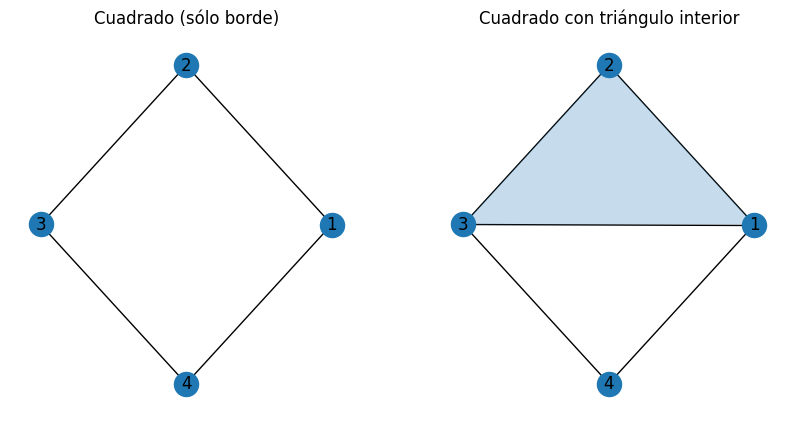

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_complex_2d(complex: SimplicialComplex, ax=None):
    # Posiciones: si los vértices son strings numerables intentamos convertir a enteros para ubicarlos en círculo
    verts = sorted(list(complex.vertices()))
    try:
        nums = [int(v) for v in verts]
        pos = {v: (np.cos(2*np.pi*i/len(verts)), np.sin(2*np.pi*i/len(verts))) for i,v in enumerate(verts)}
    except:
        pos = {v:(np.cos(2*np.pi*i/len(verts)), np.sin(2*np.pi*i/len(verts))) for i,v in enumerate(verts)}

    G = nx.Graph()
    G.add_nodes_from(verts)
    edges = [tuple(e) for e in complex.simplices_of_dim(1)]
    G.add_edges_from(edges)

    if ax is None:
        fig, ax = plt.subplots(figsize=(5,5))
    nx.draw_networkx_nodes(G, pos, ax=ax)
    nx.draw_networkx_labels(G,pos,ax=ax)
    nx.draw_networkx_edges(G,pos,ax=ax)

    # dibujar caras 2D (relleno simple con polígono)
    for tri in complex.simplices_of_dim(2):
        coords = [pos[v] for v in tri]
        polygon = plt.Polygon(coords, alpha=0.25)
        ax.add_patch(polygon)
    ax.set_axis_off()

fig, axs = plt.subplots(1,2, figsize=(10,5))
plot_complex_2d(sq_boundary, axs[0])
axs[0].set_title('Cuadrado (sólo borde)')
plot_complex_2d(sq_diag, axs[1])
axs[1].set_title('Cuadrado con triángulo interior')
plt.show()

## 6) Filtraciones desde puntos: Vietoris–Rips y persistencia (ripser)

Generaremos puntos en forma de anillo con ruido y calcularemos su diagrama de persistencia usando `ripser` (luego pueden revisar: https://ripser.scikit-tda.org/en/latest/).
Mostraremos los diagramas y los pares (nacimiento, muerte).



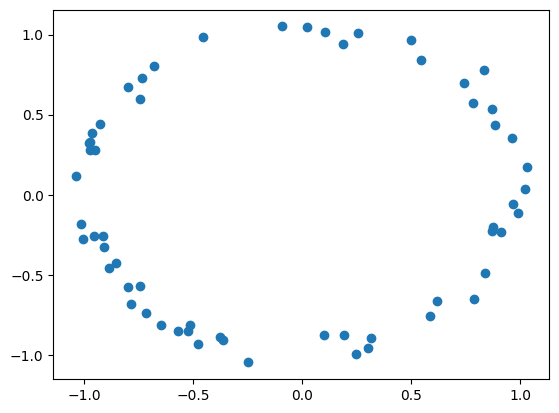

Diagramas (H0, H1):
[[0.         0.00968297]
 [0.         0.02366284]
 [0.         0.02476264]
 [0.         0.02631194]
 [0.         0.03731357]]
[[0.38838524 1.66370392]]


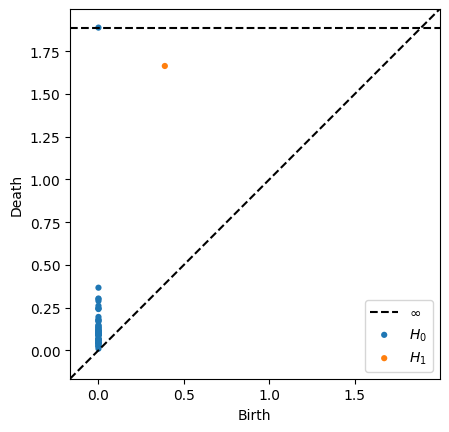

In [ ]:
import numpy as np
from ripser import ripser
from persim import plot_diagrams

# generar puntos en un círculo con ruido
def sample_noisy_circle(n=100, radius=1.0, noise=0.08, random_state=0):
    rng = np.random.RandomState(random_state)
    thetas = rng.uniform(0,2*np.pi,n)
    xs = radius * np.column_stack([np.cos(thetas), np.sin(thetas)])
    xs += rng.normal(scale=noise, size=xs.shape)
    return xs

X = sample_noisy_circle(n=60, noise=0.06)
plt.scatter(X[:,0], X[:,1])
plt.show()

# Calcular diagramas de persistencia
res = ripser(X, maxdim=1)
dgms = res['dgms']

print('Diagramas (H0, H1):')
print(dgms[0][:5])
print(dgms[1][:10])


# Plot
plot_diagrams(dgms, show=True)

Rips complex is of dimension 2 - 36050 simplices - 60 vertices.
Diagramas (H0, H1):
[(1, (0.3883852361588405, 1.6637039217583367)), (0, (0.0, inf)), (0, (0.0, 0.36631141565221004)), (0, (0.0, 0.3029891178535569)), (0, (0.0, 0.29993470267899186)), (0, (0.0, 0.2888834270428508)), (0, (0.0, 0.26025516919815717)), (0, (0.0, 0.24636454589699386)), (0, (0.0, 0.2441278297552639)), (0, (0.0, 0.24148892316477497)), (0, (0.0, 0.19532608054776715)), (0, (0.0, 0.18129806554726668)), (0, (0.0, 0.17548649279534215)), (0, (0.0, 0.17373136337262934)), (0, (0.0, 0.16833711614360297)), (0, (0.0, 0.14758962608811466)), (0, (0.0, 0.14361666043401317)), (0, (0.0, 0.13895867900237724)), (0, (0.0, 0.13234631729355098)), (0, (0.0, 0.1308381029369734)), (0, (0.0, 0.12672528837436509)), (0, (0.0, 0.11946885570564447)), (0, (0.0, 0.11653701450779211)), (0, (0.0, 0.11493207687171429)), (0, (0.0, 0.11215547890696517)), (0, (0.0, 0.11190672352062705)), (0, (0.0, 0.11095216550718548)), (0, (0.0, 0.1089244304322018))

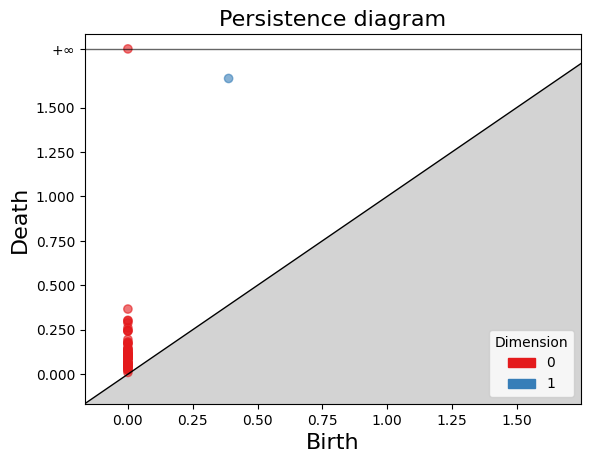

In [ ]:
import numpy as np
import gudhi

# Calcular diagramas de persistencia

rips_complex = gudhi.RipsComplex(points=X,
                                 max_edge_length=12.0)

simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
result_str = 'Rips complex is of dimension ' + repr(simplex_tree.dimension()) + ' - ' + \
    repr(simplex_tree.num_simplices()) + ' simplices - ' + \
    repr(simplex_tree.num_vertices()) + ' vertices.'
print(result_str)
fmt = '%s -> %.2f'
#for filtered_value in simplex_tree.get_filtration():
#    print(fmt % tuple(filtered_value))

diag = simplex_tree.persistence()
print('Diagramas (H0, H1):')
print(diag)
# Plot
gudhi.plot_persistence_diagram(diag)
plt.show()

**Pregunta**: En el diagrama H1 para el anillo, ¿cuántos puntos (ciclos) esperas ver y cuál tendría mayor persistencia?

## 7) Interpretación práctica

- H0 captura componentes conectadas: puntos que mueren temprano se agrupan en componentes temporales.
- H1 captura agujeros: para una nube casi circular deberíamos ver un punto en H1 con alta persistencia (el agujero central).

**Actividad**: variar el ruido y el número de puntos y observar cómo cambia la persistencia.


Noise = 0.01


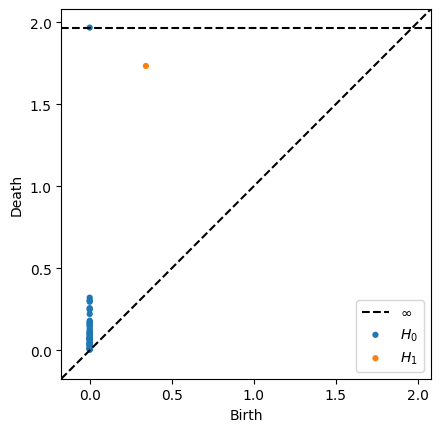


Noise = 0.06


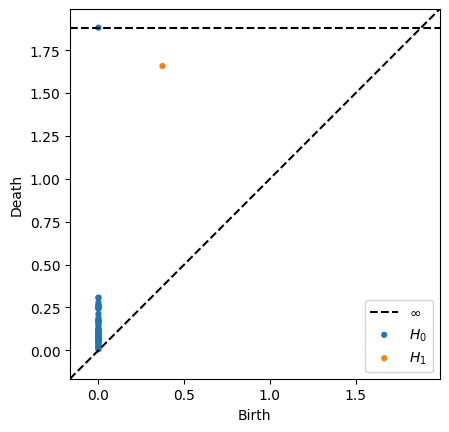


Noise = 0.2


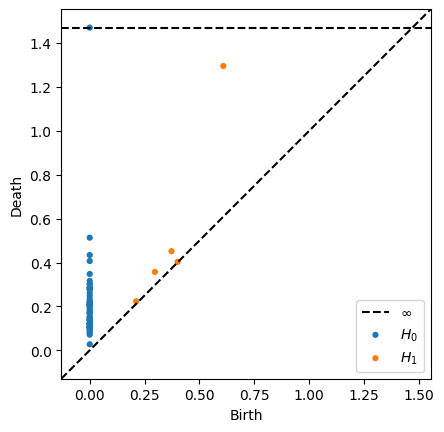

In [ ]:
# Explorar variaciones
for noise in [0.01, 0.06, 0.2]:
    X = sample_noisy_circle(n=60, noise=noise, random_state=42)
    res = ripser(X, maxdim=1)
    print('\nNoise =', noise)
    plot_diagrams(res['dgms'], show=True)

## 8) Preguntas intermedias (resumen para evaluar comprensión)

1. ¿Qué es un ciclo en dimensión 1 y cómo se distingue de una frontera?
2. ¿Por qué la identidad ∂² = 0 es esencial para definir grupos de homología?
3. En el ejemplo del círculo con ruido, ¿qué significa un punto en H1 con gran persistencia?
4. Si construyes un VR con radio muy pequeño, ¿qué esperas ver en H0 y H1?

## 10) Recursos adicionales y notas para el docente

- `ripser` y `persim` son excelentes para introducir persistencia rápido.
- Para análisis más avanzados (orientación, coeficientes reales, reducción completa) pueden usar `gudhi` o `scikit-tda`.